# Imports

In [2]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

# VGG 11 Architecture

In [5]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

## Model Helper Functions

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [8]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

In [9]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

# Loading Model and Dataset

In [10]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [11]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="/home/csalt/Haider/ATML/ATML-PA1/cifar_data",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

# Dense Model Evaluation

In [12]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has accuracy=92.95%
dense model has size=35.20 MiB


In [13]:
print(f"Model Parameter Count: {get_num_parameters(model)}")

Model Parameter Count: 9228362


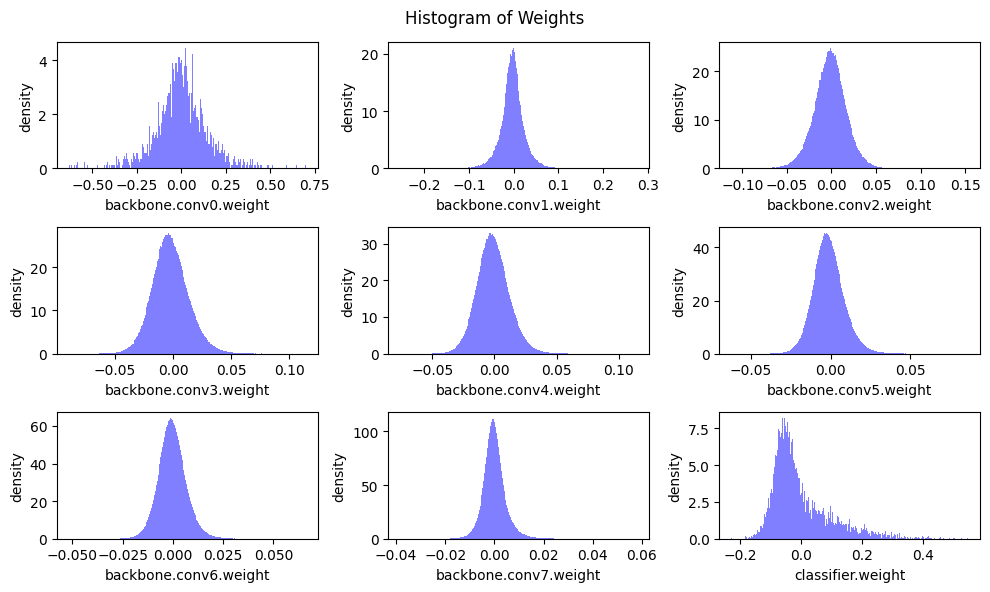

In [14]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

In [15]:
sample_images, sample_labels = next(iter(dataloader['test']))
sample_images = sample_images[:6]  # first 3 images
sample_labels = sample_labels[:6]

dummy_input = sample_images[0].unsqueeze(0).to('cpu') 

In [16]:
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()

    for _ in range(n_warmup):
        _ = model(dummy_input)

    # Measure each inference time separately
    latencies = []
    for _ in range(n_test):
        start_time = time.time()
        _ = model(dummy_input)
        end_time = time.time()
        latencies.append(end_time - start_time)

    latencies = np.array(latencies)
    mean_latency = np.mean(latencies)
    std_latency = np.std(latencies)

    return mean_latency, std_latency


model = model.to('cpu')

dense_latency = measure_latency(model, dummy_input)
dense_macs = get_model_macs(model, dummy_input)
dense_param = get_num_parameters(model)
dense_size = get_model_size(model, count_nonzero_only=False) / MiB

print(f"dense model latency: {dense_latency[0]*1e3:.2f} ± {dense_latency[1]*1e3:.2f} ms")
print(f"dense model MACs: {dense_macs / 1e6:.2f} M")
print(f"dense model parameter count: {dense_param}")
print(f"dense model size: {dense_size:.2f} MiB")

dense model latency: 2.53 ± 0.03 ms
dense model MACs: 606.16 M
dense model parameter count: 9228362
dense model size: 35.20 MiB


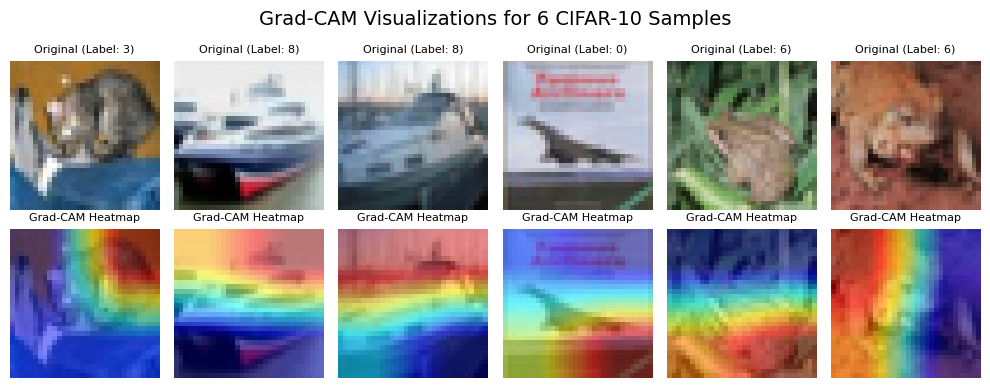

In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device).eval()

target_layer = model.backbone[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

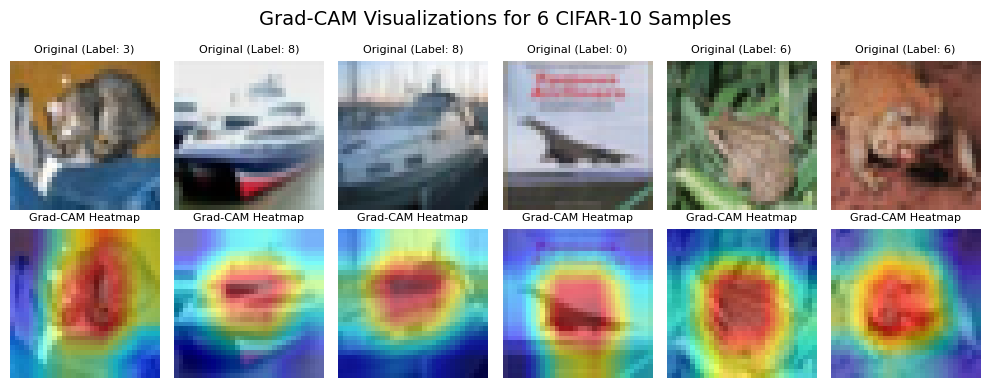

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device).eval()

target_layer = model.backbone[-3]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Unstructured Pruning

In [58]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(sparsity * num_elements)
    importance = torch.abs(tensor)
    if num_zeros > 0:
        threshold, _ = torch.kthvalue(importance.view(-1), k=num_zeros)
    else:
        threshold = 0.0
    mask = importance > threshold
    tensor.mul_(mask)

    return mask

In [59]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [101]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.3, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.91it/s]

    sparsity=0.30: accuracy=92.60%

scanning 0/9 weight - backbone.conv0.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.91it/s]

    sparsity=0.40: accuracy=92.42%

scanning 0/9 weight - backbone.conv0.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=91.19%

scanning 0/9 weight - backbone.conv0.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]

    sparsity=0.60: accuracy=87.55%

scanning 0/9 weight - backbone.conv0.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.90it/s]

    sparsity=0.70: accuracy=83.39%

scanning 0/9 weight - backbone.conv0.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]

    sparsity=0.80: accuracy=69.43%

scanning 0/9 weight - backbone.conv0.weight: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.60%, 92.42%, 91.19%, 87.55%, 83.39%, 69.43%, 31.82%]

scanning 1/9 weight - backbone.conv1.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.91it/s]

    sparsity=0.30: accuracy=92.97%

scanning 1/9 weight - backbone.conv1.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.90it/s]

    sparsity=0.40: accuracy=92.93%

scanning 1/9 weight - backbone.conv1.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=92.87%

scanning 1/9 weight - backbone.conv1.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.87it/s]

    sparsity=0.60: accuracy=92.71%

scanning 1/9 weight - backbone.conv1.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.88it/s]

    sparsity=0.70: accuracy=92.40%

scanning 1/9 weight - backbone.conv1.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.88it/s]

    sparsity=0.80: accuracy=91.32%

scanning 1/9 weight - backbone.conv1.weight: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.97%, 92.93%, 92.87%, 92.71%, 92.40%, 91.32%, 84.78%]

scanning 2/9 weight - backbone.conv2.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.90it/s]

    sparsity=0.30: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.90it/s]

    sparsity=0.40: accuracy=92.94%

scanning 2/9 weight - backbone.conv2.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=92.64%

scanning 2/9 weight - backbone.conv2.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]

    sparsity=0.60: accuracy=92.46%

scanning 2/9 weight - backbone.conv2.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.91it/s]

    sparsity=0.70: accuracy=91.77%

scanning 2/9 weight - backbone.conv2.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]

    sparsity=0.80: accuracy=89.85%

scanning 2/9 weight - backbone.conv2.weight: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.94%, 92.64%, 92.46%, 91.77%, 89.85%, 78.56%]

scanning 3/9 weight - backbone.conv3.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.91it/s]

    sparsity=0.30: accuracy=92.91%

scanning 3/9 weight - backbone.conv3.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.91it/s]

    sparsity=0.40: accuracy=92.86%

scanning 3/9 weight - backbone.conv3.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=92.71%

scanning 3/9 weight - backbone.conv3.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]

    sparsity=0.60: accuracy=92.23%

scanning 3/9 weight - backbone.conv3.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.91it/s]

    sparsity=0.70: accuracy=91.09%

scanning 3/9 weight - backbone.conv3.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]

    sparsity=0.80: accuracy=85.34%

scanning 3/9 weight - backbone.conv3.weight: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.91%, 92.86%, 92.71%, 92.23%, 91.09%, 85.34%, 51.29%]

scanning 4/9 weight - backbone.conv4.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.91it/s]

    sparsity=0.30: accuracy=92.87%

scanning 4/9 weight - backbone.conv4.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.91it/s]

    sparsity=0.40: accuracy=92.87%

scanning 4/9 weight - backbone.conv4.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=92.68%

scanning 4/9 weight - backbone.conv4.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]

    sparsity=0.60: accuracy=92.22%

scanning 4/9 weight - backbone.conv4.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.91it/s]

    sparsity=0.70: accuracy=89.47%

scanning 4/9 weight - backbone.conv4.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]

    sparsity=0.80: accuracy=76.86%

scanning 4/9 weight - backbone.conv4.weight: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.87%, 92.87%, 92.68%, 92.22%, 89.47%, 76.86%, 38.78%]

scanning 5/9 weight - backbone.conv5.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.91it/s]

    sparsity=0.30: accuracy=92.94%

scanning 5/9 weight - backbone.conv5.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.91it/s]

    sparsity=0.40: accuracy=92.91%

scanning 5/9 weight - backbone.conv5.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.91it/s]

    sparsity=0.50: accuracy=92.71%

scanning 5/9 weight - backbone.conv5.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.91it/s]

    sparsity=0.60: accuracy=92.63%

scanning 5/9 weight - backbone.conv5.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.91it/s]

    sparsity=0.70: accuracy=91.88%

scanning 5/9 weight - backbone.conv5.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.91it/s]

    sparsity=0.80: accuracy=89.91%

scanning 5/9 weight - backbone.conv5.weight: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.91%, 92.71%, 92.63%, 91.88%, 89.91%, 82.21%]

scanning 6/9 weight - backbone.conv6.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.57it/s]

    sparsity=0.30: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.75it/s]

    sparsity=0.40: accuracy=92.95%

scanning 6/9 weight - backbone.conv6.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.81it/s]

    sparsity=0.50: accuracy=92.86%

scanning 6/9 weight - backbone.conv6.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.84it/s]

    sparsity=0.60: accuracy=92.65%

scanning 6/9 weight - backbone.conv6.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.86it/s]

    sparsity=0.70: accuracy=92.10%

scanning 6/9 weight - backbone.conv6.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.86it/s]

    sparsity=0.80: accuracy=90.58%

scanning 6/9 weight - backbone.conv6.weight: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.95%, 92.95%, 92.86%, 92.65%, 92.10%, 90.58%, 83.64%]

scanning 7/9 weight - backbone.conv7.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.87it/s]

    sparsity=0.30: accuracy=92.93%

scanning 7/9 weight - backbone.conv7.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.89it/s]

    sparsity=0.40: accuracy=92.93%

scanning 7/9 weight - backbone.conv7.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.90it/s]

    sparsity=0.50: accuracy=92.90%

scanning 7/9 weight - backbone.conv7.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.90it/s]

    sparsity=0.60: accuracy=92.89%

scanning 7/9 weight - backbone.conv7.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.90it/s]

    sparsity=0.70: accuracy=92.81%

scanning 7/9 weight - backbone.conv7.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.89it/s]

    sparsity=0.80: accuracy=92.63%

scanning 7/9 weight - backbone.conv7.weight: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.93%, 92.93%, 92.90%, 92.89%, 92.81%, 92.63%, 91.34%]

scanning 8/9 weight - classifier.weight:  14%|█▍        | 1/7 [00:00<00:03,  1.89it/s]

    sparsity=0.30: accuracy=92.94%

scanning 8/9 weight - classifier.weight:  29%|██▊       | 2/7 [00:01<00:02,  1.89it/s]

    sparsity=0.40: accuracy=92.91%

scanning 8/9 weight - classifier.weight:  43%|████▎     | 3/7 [00:01<00:02,  1.90it/s]

    sparsity=0.50: accuracy=92.83%

scanning 8/9 weight - classifier.weight:  57%|█████▋    | 4/7 [00:02<00:01,  1.90it/s]

    sparsity=0.60: accuracy=92.82%

scanning 8/9 weight - classifier.weight:  71%|███████▏  | 5/7 [00:02<00:01,  1.90it/s]

    sparsity=0.70: accuracy=92.97%

scanning 8/9 weight - classifier.weight:  86%|████████▌ | 6/7 [00:03<00:00,  1.89it/s]

    sparsity=0.80: accuracy=92.66%

scanning 8/9 weight - classifier.weight: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

    sparsity=[0.30,0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[92.94%, 92.91%, 92.83%, 92.82%, 92.97%, 92.66%, 92.52%]

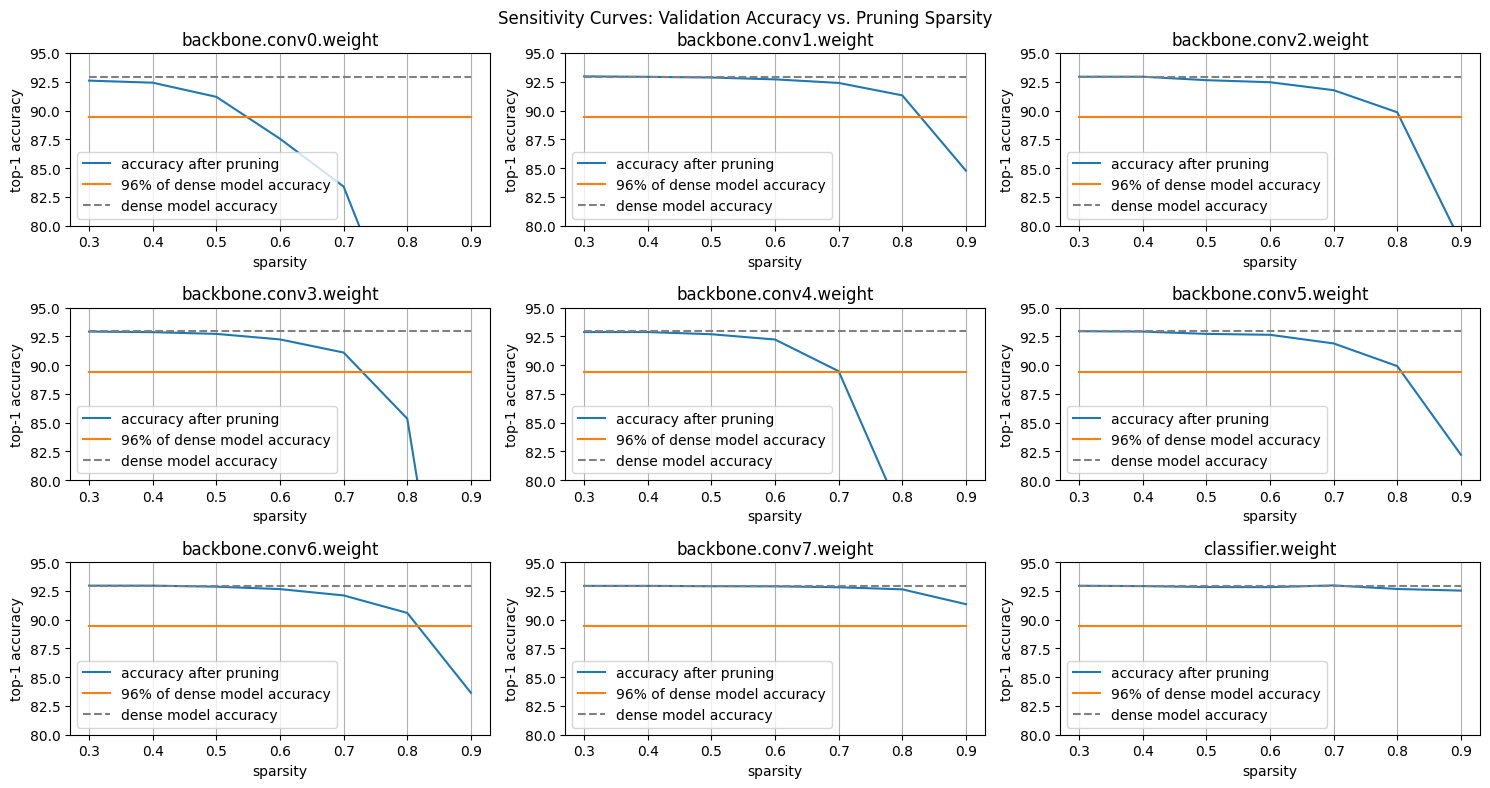

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            line_2 = ax.plot(sparsities, [dense_model_accuracy] * len(sparsities), linestyle='--', color='gray')
            ax.set_xticks(np.arange(start=0.3, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy',
                'dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

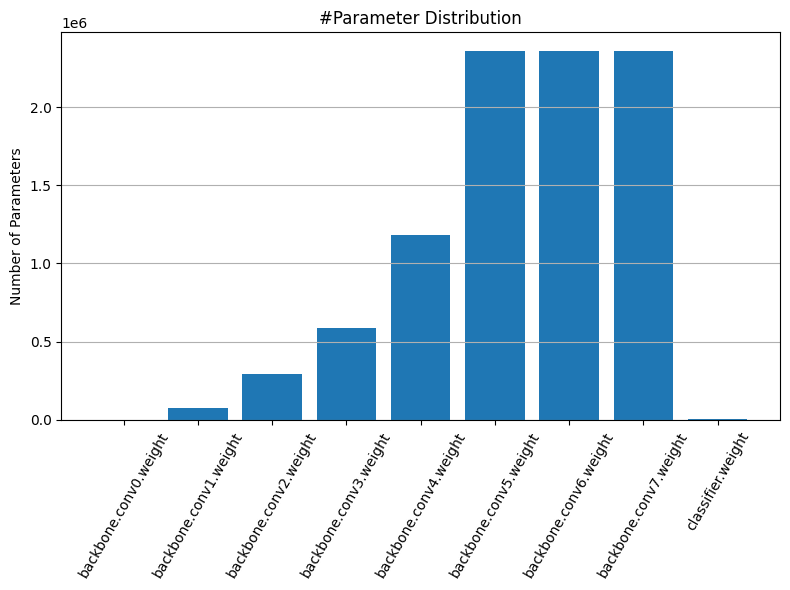

In [103]:
#  Layers with more #parameters require larger sparsities.
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



In [60]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.2,
    'backbone.conv1.weight': 0.2,
    'backbone.conv2.weight': 0.3,
    'backbone.conv3.weight': 0.6,
    'backbone.conv4.weight': 0.6,
    'backbone.conv5.weight': 0.7,
    'backbone.conv6.weight': 0.75,
    'backbone.conv7.weight': 0.8,
    'classifier.weight': 0.5
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

The sparsity of each layer becomes
  backbone.conv0.weight: 0.20
  backbone.conv1.weight: 0.20
  backbone.conv2.weight: 0.30
  backbone.conv3.weight: 0.60
  backbone.conv4.weight: 0.60
  backbone.conv5.weight: 0.70
  backbone.conv6.weight: 0.75
  backbone.conv7.weight: 0.80
  classifier.weight: 0.50
Sparse model has size=10.50 MiB = 29.82% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=91.07% before fintuning


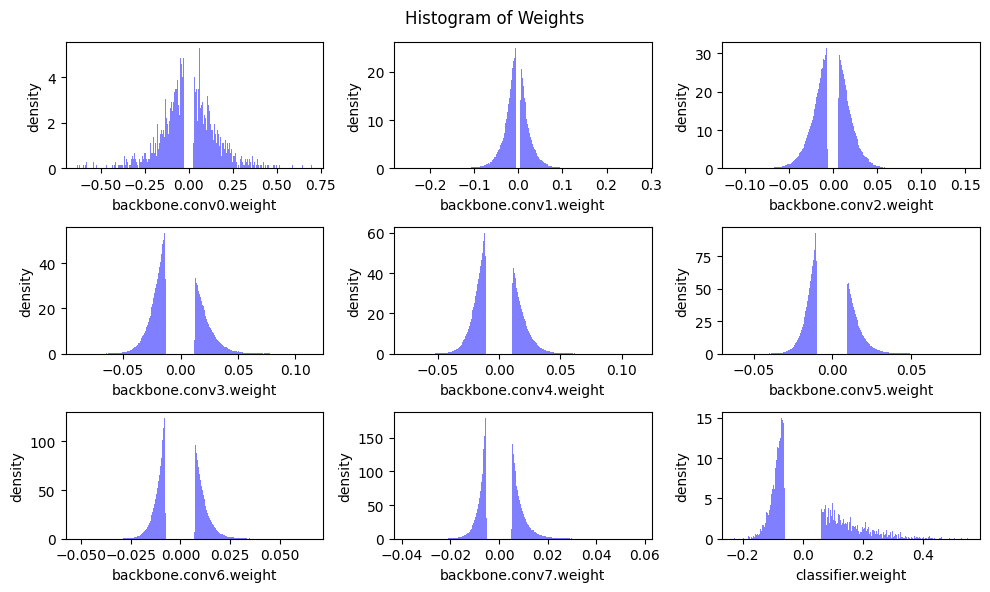

In [61]:
pruner = FineGrainedPruner(model, sparsity_dict)
# print(f'After pruning with sparsity dictionary')
# for name, sparsity in sparsity_dict.items():
#     print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

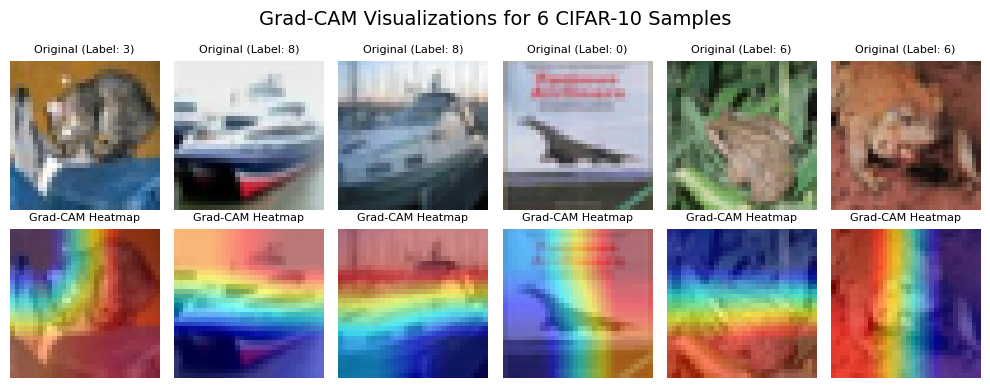

In [62]:
model = model.to(device).eval()

target_layer = model.backbone[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

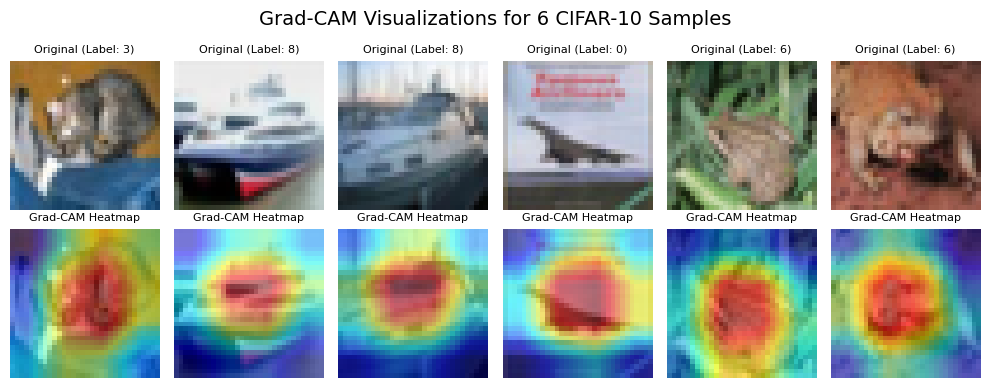

In [63]:
model = model.to(device).eval()

target_layer = model.backbone[-3]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Finetune the fine-grained pruned model

In [64]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


    Epoch 1 Accuracy 92.77% / Best Accuracy: 92.77%


    Epoch 2 Accuracy 92.76% / Best Accuracy: 92.77%


    Epoch 3 Accuracy 92.85% / Best Accuracy: 92.85%


    Epoch 4 Accuracy 92.83% / Best Accuracy: 92.85%


    Epoch 5 Accuracy 92.88% / Best Accuracy: 92.88%


Run the following cell to see the information of best finetuned sparse model.

In [65]:
# load the best sparse model checkpoint to evaluate the final performance
# torch.save(best_sparse_model_checkpoint, 'best_fine_grained_pruned_sparse_model.pth')
best_sparse_model_checkpoint = torch.load('best_fine_grained_pruned_sparse_model.pth')
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
sparsity = get_model_sparsity(model)
print(f"Sparse model has overall sparsity={sparsity:.2f}")
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has overall sparsity=0.70
Sparse model has size=10.50 MiB = 29.82% of dense model size


Sparse model has accuracy=92.89% after fintuning


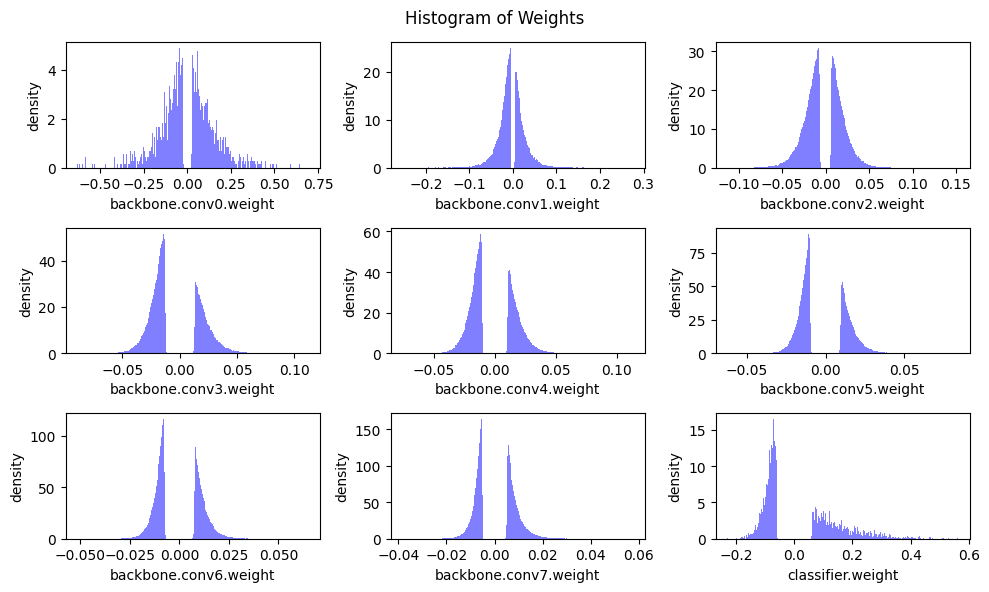

In [66]:
plot_weight_distribution(model, count_nonzero_only=True)

In [67]:
model = model.to('cpu')

unstructured_latency = measure_latency(model, dummy_input)
unstructured_macs = get_model_macs(model, dummy_input)
unstructured_param = get_num_parameters(model)
unstructured_size = get_model_size(model, count_nonzero_only=False) / MiB

print(f"unstructured model latency: {unstructured_latency[0]*1e3:.2f} ± {unstructured_latency[1]*1e3:.2f} ms")
print(f"unstructured model MACs: {unstructured_macs / 1e6:.2f} M")
print(f"unstructured model parameter count: {unstructured_param}")
print(f"unstructured model size: {unstructured_size:.2f} MiB")

unstructured model latency: 2.33 ± 0.10 ms
unstructured model MACs: 606.16 M
unstructured model parameter count: 9228362
unstructured model size: 35.20 MiB


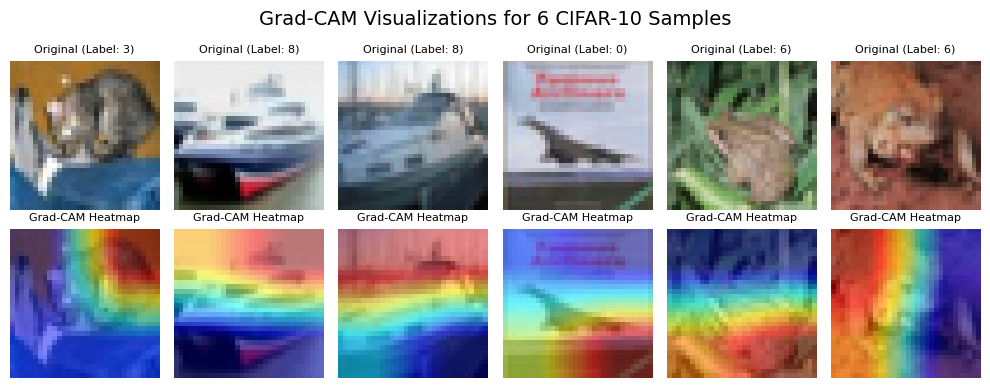

In [68]:
model = model.to(device).eval()

target_layer = model.backbone[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

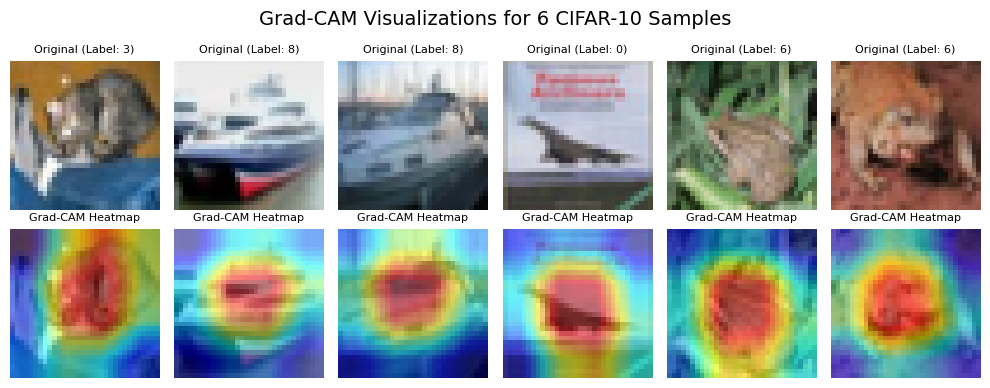

In [69]:
model = model.to(device).eval()

target_layer = model.backbone[-3]
cam = GradCAM(model=model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [111]:
sparsity_levels = []
accuracies_normal = []
accuracies_finetuning = []

multipliers = np.linspace(0.1, 1.0, 8)
for multiplier in multipliers:
    recover_model()

    sparsity_dict = {
        'backbone.conv0.weight': 0.2,
        'backbone.conv1.weight': 0.2,
        'backbone.conv2.weight': 0.3,
        'backbone.conv3.weight': 0.6,
        'backbone.conv4.weight': 0.6,
        'backbone.conv5.weight': 0.7,
        'backbone.conv6.weight': 0.75,
        'backbone.conv7.weight': 0.8,
        'classifier.weight': 0.5
    }

    adjusted_sparsity_dict = {
        name: float(min(1.0, sparsity * float(multiplier)))
        for name, sparsity in sparsity_dict.items()
    }

    pruner = FineGrainedPruner(model, adjusted_sparsity_dict)
    sparse_model_accuracy = evaluate(model, dataloader['test'])
    overall_sparsity = get_model_sparsity(model)

    sparsity_levels.append(overall_sparsity)
    accuracies_normal.append(sparse_model_accuracy)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    for epoch in range(3):
        train(model, dataloader['train'], criterion, optimizer, scheduler,
            callbacks=[lambda: pruner.apply(model)])
        accuracy = evaluate(model, dataloader['test'])
        is_best = accuracy > best_accuracy
        if is_best:
            best_accuracy = accuracy
    accuracies_finetuning.append(best_accuracy)

    print(f'Multiplier={multiplier:.2f}, Overall sparsity={overall_sparsity*100:.2f}%, Accuracy={sparse_model_accuracy:.2f}%, Fine-tuned Accuracy={best_accuracy:.2f}%')

Multiplier=0.10, Overall sparsity=7.02%, Accuracy=92.95%, Fine-tuned Accuracy=92.97%


Multiplier=0.23, Overall sparsity=16.04%, Accuracy=92.95%, Fine-tuned Accuracy=93.10%


Multiplier=0.36, Overall sparsity=25.06%, Accuracy=92.90%, Fine-tuned Accuracy=92.99%


Multiplier=0.49, Overall sparsity=34.09%, Accuracy=92.82%, Fine-tuned Accuracy=92.98%


Multiplier=0.61, Overall sparsity=43.11%, Accuracy=92.80%, Fine-tuned Accuracy=92.99%


Multiplier=0.74, Overall sparsity=52.13%, Accuracy=92.50%, Fine-tuned Accuracy=93.01%


Multiplier=0.87, Overall sparsity=61.15%, Accuracy=92.04%, Fine-tuned Accuracy=92.95%


Multiplier=1.00, Overall sparsity=70.18%, Accuracy=91.07%, Fine-tuned Accuracy=92.88%


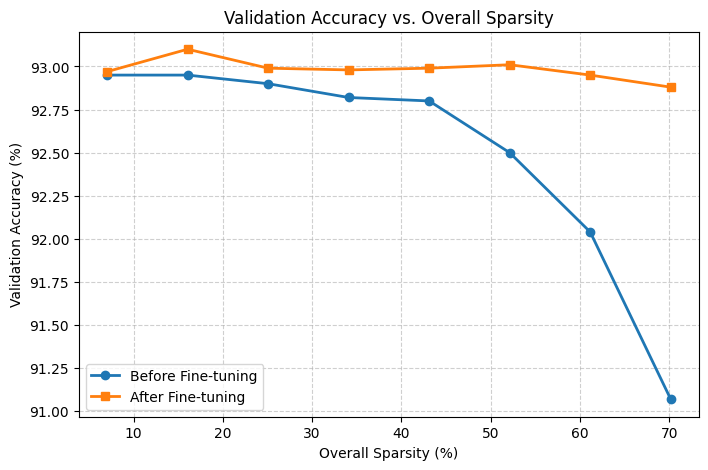

In [112]:
# --- Plots --- 
plt.figure(figsize=(8,5))
plt.plot(np.array(sparsity_levels)*100, accuracies_normal, marker='o', linewidth=2, label='Before Fine-tuning')
plt.plot(np.array(sparsity_levels)*100, accuracies_finetuning, marker='s', linewidth=2, label='After Fine-tuning')
plt.title('Validation Accuracy vs. Overall Sparsity')
plt.xlabel('Overall Sparsity (%)')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# Structured Pruning

In [18]:
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

dense model has accuracy=92.95%


In [19]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round(channels * (1 - prune_ratio)))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight,p=2)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

In [20]:
@torch.no_grad()
def structured_sensitivity_scan(model, dataloader, prune_ratios, evaluate_fn, device='cuda'):
    """
    Perform structured pruning sensitivity analysis across convolutional layers.
    For each conv layer:
        - progressively prune that layer only
        - evaluate model accuracy
        - restore model to original
    """
    model = copy.deepcopy(model).to(device)
    model.eval()

    # Fetch conv layers
    all_convs = [m for m in model.backbone if isinstance(m, torch.nn.Conv2d)]
    n_layers = len(all_convs)

    # Store results per layer
    all_accuracies = []

    for i_layer in range(n_layers - 1):  # skip classifier conv connections
        print(f"\nAnalyzing Conv Layer {i_layer} | shape = {all_convs[i_layer].weight.shape}")
        layer_accs = []

        for ratio in tqdm(prune_ratios, desc=f"Layer {i_layer} pruning"):
            # Build pruning ratio list: only current layer gets pruned
            layer_prune_ratios = [0.0] * (n_layers - 1)
            layer_prune_ratios[i_layer] = ratio

            # Apply channel pruning
            pruned_model = channel_prune(model, prune_ratio=layer_prune_ratios).to(device)
            pruned_model.eval()

            # Evaluate accuracy
            acc = evaluate_fn(pruned_model, dataloader)
            layer_accs.append(acc)

            del pruned_model
            torch.cuda.empty_cache()

        all_accuracies.append(layer_accs)

    return prune_ratios, all_accuracies

In [21]:
def plot_structured_sensitivity(prune_ratios, accuracies, dense_acc, model):
    num_layers = len(accuracies)
    n_cols = 3
    n_rows = int(np.ceil(num_layers / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axes = axes.ravel()

    lower_bound = dense_acc * 0.96  # e.g., 96% of dense model accuracy

    all_convs = [m for m in model.backbone if isinstance(m, torch.nn.Conv2d)]

    for i, accs in enumerate(accuracies):
        ax = axes[i]
        ax.plot(prune_ratios, accs, label='accuracy after pruning')
        ax.axhline(y=dense_acc, color='gray', linestyle='--', label='dense model accuracy')
        ax.axhline(y=lower_bound, color='orange', linestyle='-', label='96% dense acc')
        ax.set_title(f"conv{i} ({all_convs[i].in_channels}→{all_convs[i].out_channels})")
        ax.set_xlabel('pruning ratio')
        ax.set_ylabel('top-1 accuracy')
        ax.set_ylim(40, dense_acc + 2)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Structured Sensitivity Curves: Validation Accuracy vs. Channel Pruning Sparsity", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [22]:
prune_ratios = np.linspace(0.3, 0.9, 7)
dense_acc = evaluate(model, dataloader['test'])

ratios, structured_results = structured_sensitivity_scan(
    model, dataloader['test'], prune_ratios=prune_ratios,
    evaluate_fn=evaluate, device='cuda'
)



Analyzing Conv Layer 0 | shape = torch.Size([64, 3, 3, 3])


Layer 0 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]



Analyzing Conv Layer 1 | shape = torch.Size([128, 64, 3, 3])


Layer 1 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]



Analyzing Conv Layer 2 | shape = torch.Size([256, 128, 3, 3])


Layer 2 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]



Analyzing Conv Layer 3 | shape = torch.Size([256, 256, 3, 3])


Layer 3 pruning: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]



Analyzing Conv Layer 4 | shape = torch.Size([512, 256, 3, 3])


Layer 4 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]



Analyzing Conv Layer 5 | shape = torch.Size([512, 512, 3, 3])


Layer 5 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]



Analyzing Conv Layer 6 | shape = torch.Size([512, 512, 3, 3])


Layer 6 pruning: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


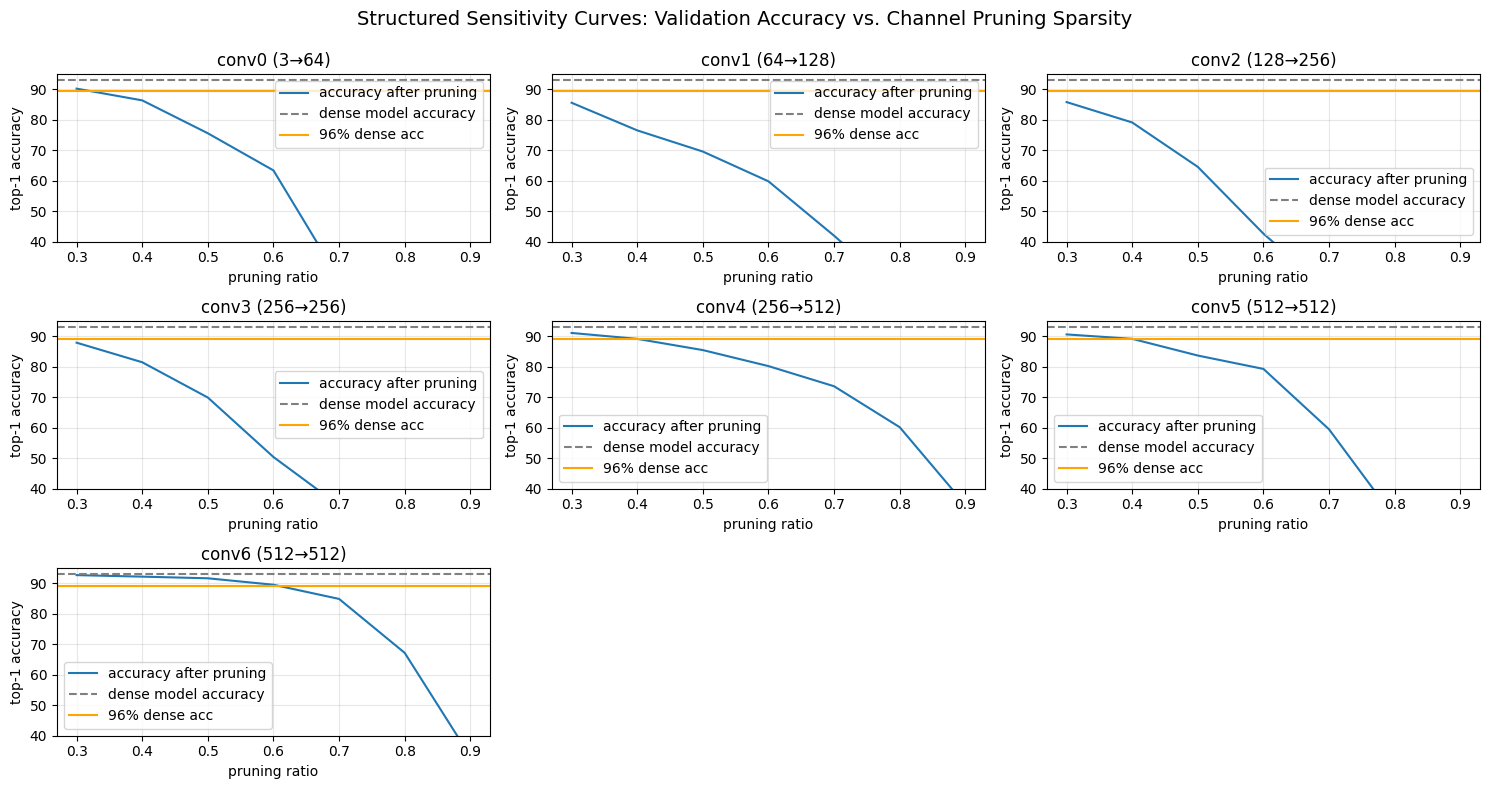

In [23]:
plot_structured_sensitivity(ratios, structured_results, dense_acc, model)

In [49]:
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, 0.2)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
size_ratio = get_num_parameters(pruned_model, count_nonzero_only=False) / get_num_parameters(model, count_nonzero_only=False)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")
print(f"pruned model has size ratio={size_ratio:.2f}")

pruned model has accuracy=52.01%
pruned model has size ratio=0.68


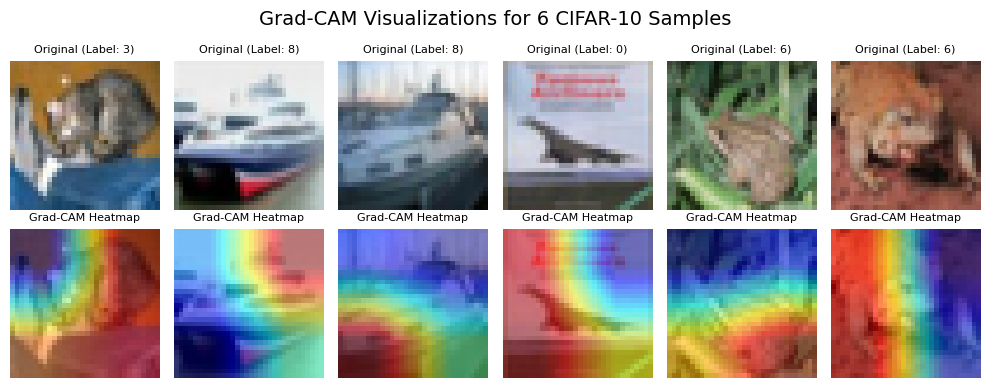

In [50]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-1]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

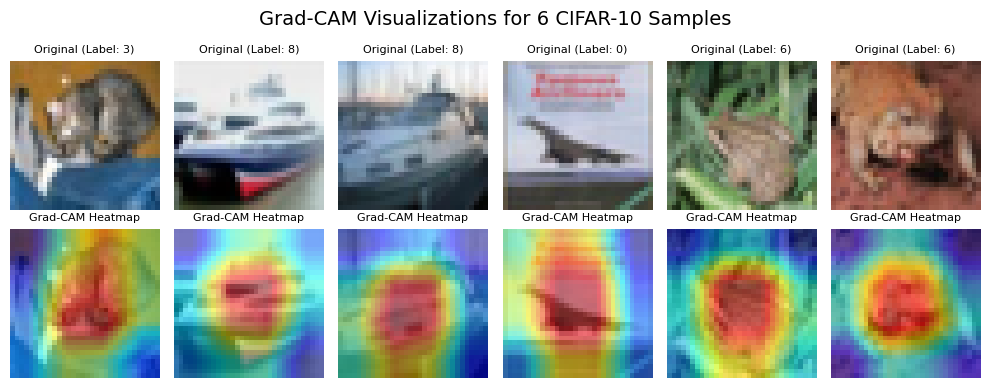

In [51]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-3]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [52]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 92.19% / Best Accuracy: 92.19%


Epoch 2 Accuracy 92.28% / Best Accuracy: 92.28%


Epoch 3 Accuracy 92.36% / Best Accuracy: 92.36%


Epoch 4 Accuracy 92.63% / Best Accuracy: 92.63%


Epoch 5 Accuracy 92.63% / Best Accuracy: 92.63%


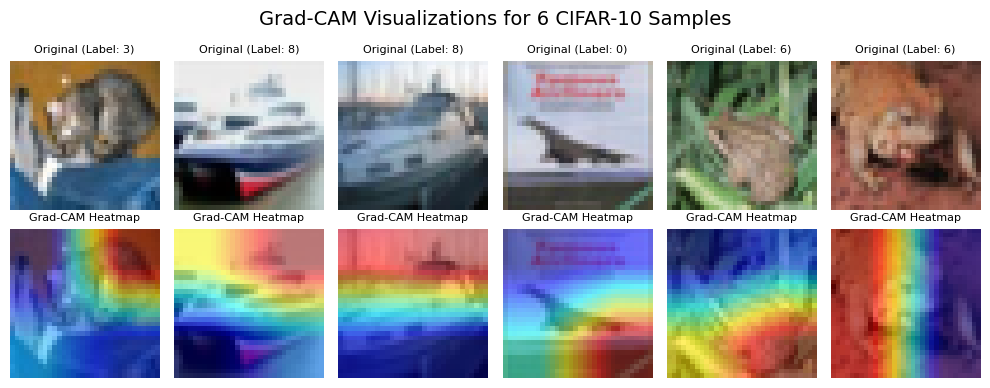

In [53]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-1]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

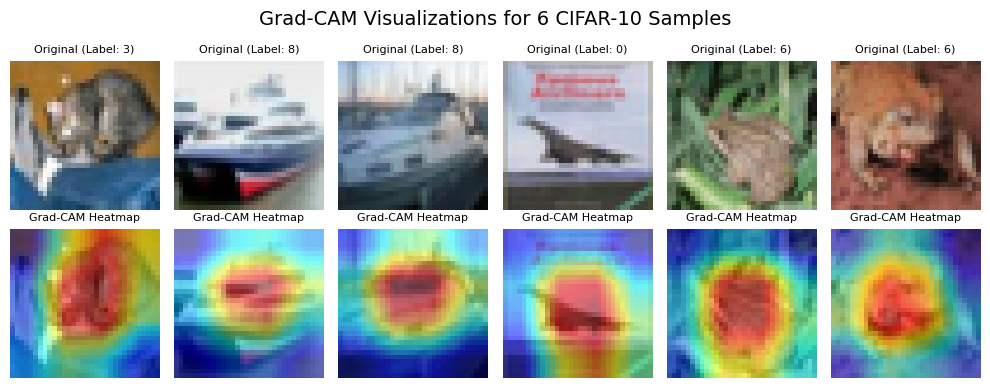

In [54]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-3]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [28]:
pruned_model = pruned_model.to('cpu')

structured_latency = measure_latency(pruned_model, dummy_input)
structured_macs = get_model_macs(pruned_model, dummy_input)
structured_param = get_num_parameters(pruned_model)
structured_size = get_model_size(pruned_model, count_nonzero_only=False) / MiB

print(f"structured model latency: {structured_latency[0]*1e3:.2f} ± {structured_latency[1]*1e3:.2f} ms")
print(f"structured model MACs: {structured_macs / 1e6:.2f} M")
print(f"structured model parameter count: {structured_param}")
print(f"structured model size: {structured_size:.2f} MiB")

structured model latency: 1.57 ± 0.05 ms
structured model MACs: 394.36 M
structured model parameter count: 6295880
structured model size: 24.02 MiB


In [46]:

sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, [0.4,0.3,0.4,0.5,0.5,0.5,0.6])
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
size_ratio = get_num_parameters(pruned_model, count_nonzero_only=False) / get_num_parameters(model, count_nonzero_only=False)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")
print(f"pruned model has size ratio={size_ratio:.2f}")


eval:  80%|████████  | 16/20 [00:00<00:00, 74.27it/s]

pruned model has accuracy=15.46%
pruned model has size ratio=0.29


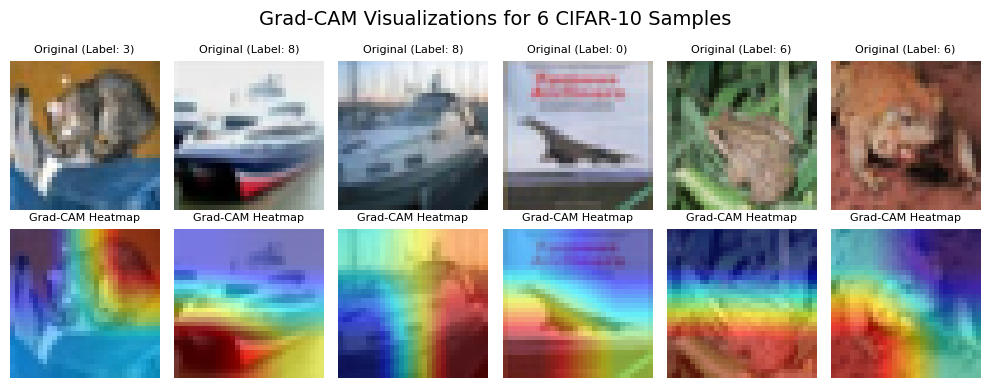

In [47]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-1]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

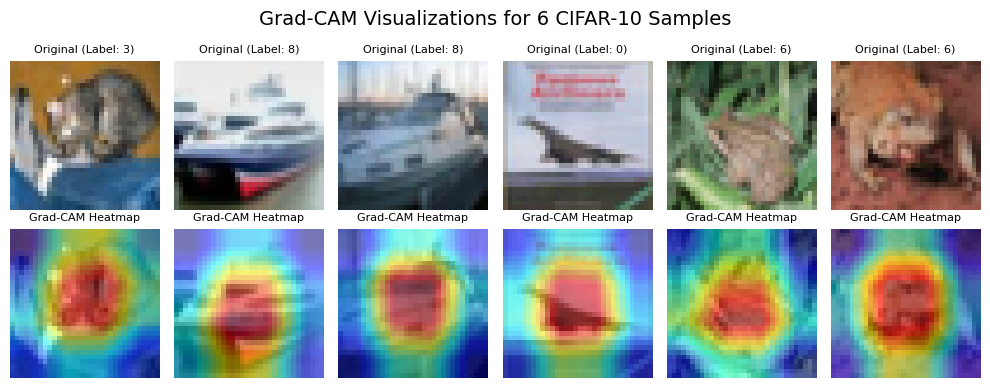

In [48]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-3]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [39]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Epoch 1 Accuracy 90.04% / Best Accuracy: 90.04%


Epoch 2 Accuracy 90.60% / Best Accuracy: 90.60%


Epoch 3 Accuracy 91.19% / Best Accuracy: 91.19%


Epoch 4 Accuracy 91.23% / Best Accuracy: 91.23%


Epoch 5 Accuracy 91.84% / Best Accuracy: 91.84%


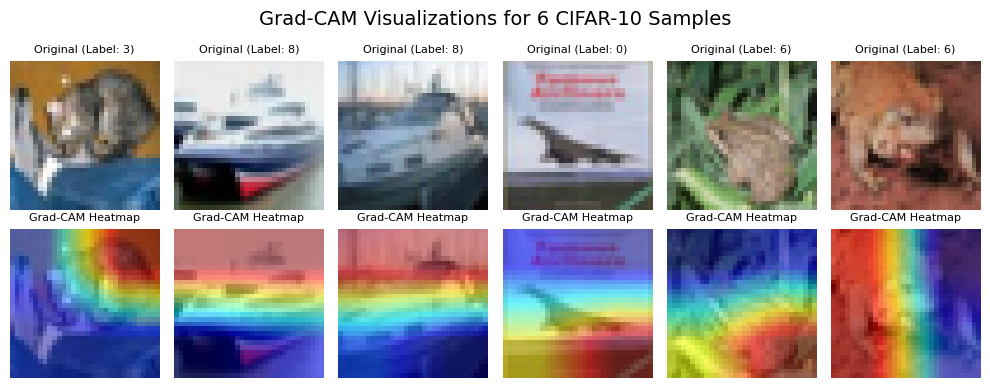

In [ ]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-1]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

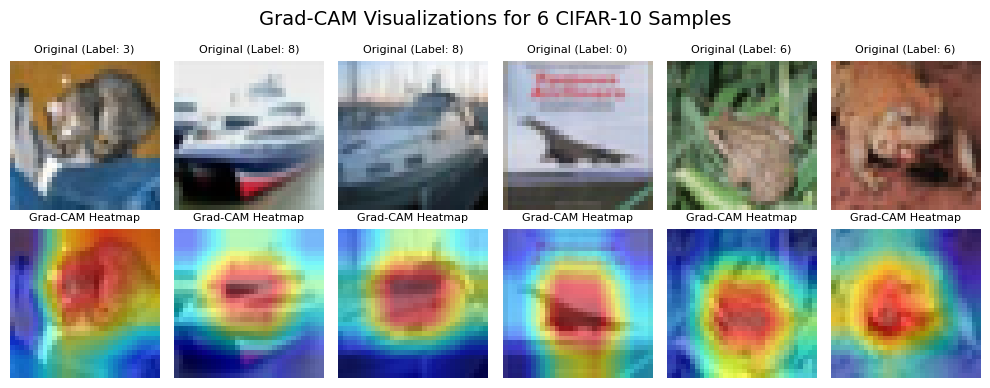

In [45]:
pruned_model = pruned_model.to(device).eval()

target_layer = pruned_model.backbone[-3]
cam = GradCAM(model=pruned_model, target_layers=[target_layer])

# Plot setup
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
fig.suptitle("Grad-CAM Visualizations for 6 CIFAR-10 Samples", fontsize=14)

for i in range(6):
    input_tensor = sample_images[i].unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    # Convert to RGB image for visualization
    rgb_img = np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0))
    rgb_img = np.clip(rgb_img, 0, 1)

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original
    axes[0, i].imshow(rgb_img)
    axes[0, i].set_title(f"Original (Label: {sample_labels[i].item()})", fontsize=8)
    axes[0, i].axis('off')

    # Plot Grad-CAM heatmap
    axes[1, i].imshow(visualization)
    axes[1, i].set_title("Grad-CAM Heatmap", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [41]:
pruned_model = pruned_model.to('cpu')

structured_latency = measure_latency(pruned_model, dummy_input)
structured_macs = get_model_macs(pruned_model, dummy_input)
structured_param = get_num_parameters(pruned_model)
structured_size = get_model_size(pruned_model, count_nonzero_only=False) / MiB

print(f"structured model latency: {structured_latency[0]*1e3:.2f} ± {structured_latency[1]*1e3:.2f} ms")
print(f"structured model MACs: {structured_macs / 1e6:.2f} M")
print(f"structured model parameter count: {structured_param}")
print(f"structured model size: {structured_size:.2f} MiB")

structured model latency: 0.87 ± 0.04 ms
structured model MACs: 189.47 M
structured model parameter count: 2644058
structured model size: 10.09 MiB
